# Open Famous People Faces Dataset Analysis

Imports and settings

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from IPython.display import display

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

BASE_DIR = Path("open_famous_people_faces")

Loading the dataset into a df with metadata (name, width, height, file size)

In [2]:
def load_faces(base_dir: Path) -> pd.DataFrame:
    records = []
    for celeb_path in base_dir.iterdir():
        if not celeb_path.is_dir():
            continue
        celeb_name = celeb_path.name
        for img_path in celeb_path.glob("*.jpg"):
            try:
                with Image.open(img_path) as img:
                    w, h = img.size
                size_kb = img_path.stat().st_size / 1024
                records.append(
                    {
                        "celebrity": celeb_name,
                        "image_path": str(img_path),
                        "file_size_kb": round(size_kb, 2),
                        "width": w,
                        "height": h,
                    }
                )
            except Exception as e:
                print(f"Warning: Skipping corrupted file {img_path}: {e}")
    return pd.DataFrame(records)


df = load_faces(BASE_DIR)
print(f"Loaded {len(df):,} images from {df['celebrity'].nunique()} celebrities.")

Loaded 3,025 images from 258 celebrities.


In [3]:
print("\n--- Dataset Overview ---")
display(df.head())

print("\n--- Missing / Corrupted ---")
print(f"Missing paths: {df['image_path'].isnull().sum()}")
print(f"Zero-size files: {(df['file_size_kb'] == 0).sum()}")

dup_paths = df.duplicated(subset=["image_path"], keep=False).sum()
print(f"Duplicate paths: {dup_paths}")


--- Dataset Overview ---


,celebrity,image_path,file_size_kb,width,height
0,aaron_taylor_johnson,open_famous_people_faces\aaron_taylor_johnson\...,12.57,167,201
1,aaron_taylor_johnson,open_famous_people_faces\aaron_taylor_johnson\...,5.96,101,117
2,aaron_taylor_johnson,open_famous_people_faces\aaron_taylor_johnson\...,70.29,356,423
3,aaron_taylor_johnson,open_famous_people_faces\aaron_taylor_johnson\...,9.53,131,157
4,aaron_taylor_johnson,open_famous_people_faces\aaron_taylor_johnson\...,49.05,299,364



--- Missing / Corrupted ---
Missing paths: 0
Zero-size files: 0
Duplicate paths: 0


Analyzing counts of images per celebrity

In [4]:
count_per_celeb = (
    df["celebrity"]
    .value_counts()
    .rename_axis("celebrity")
    .reset_index(name="image_count")
)

print(f"\nTotal celebrities: {len(count_per_celeb)}")
print("Top 10 with most images:")
display(count_per_celeb.head(10))

display(count_per_celeb.describe())


Total celebrities: 258
Top 10 with most images:


,celebrity,image_count
0,angelina_jolie,29
1,amanda_seyfried,27
2,adam_sandler,26
3,jesse_eisenberg,25
4,brad_pitt,24
5,octavia_spencer,23
6,annasophia_robb,22
7,channing_tatum,22
8,abigail_breslin,22
9,aaron_taylor_johnson,22


,image_count
count,258.000000
mean,11.724806
std,4.165572
min,6.000000
25%,9.000000
50%,10.500000
75%,13.000000
max,29.000000


C:\Users\Mikhailov\AppData\Local\Temp\ipykernel_11948\2772028164.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


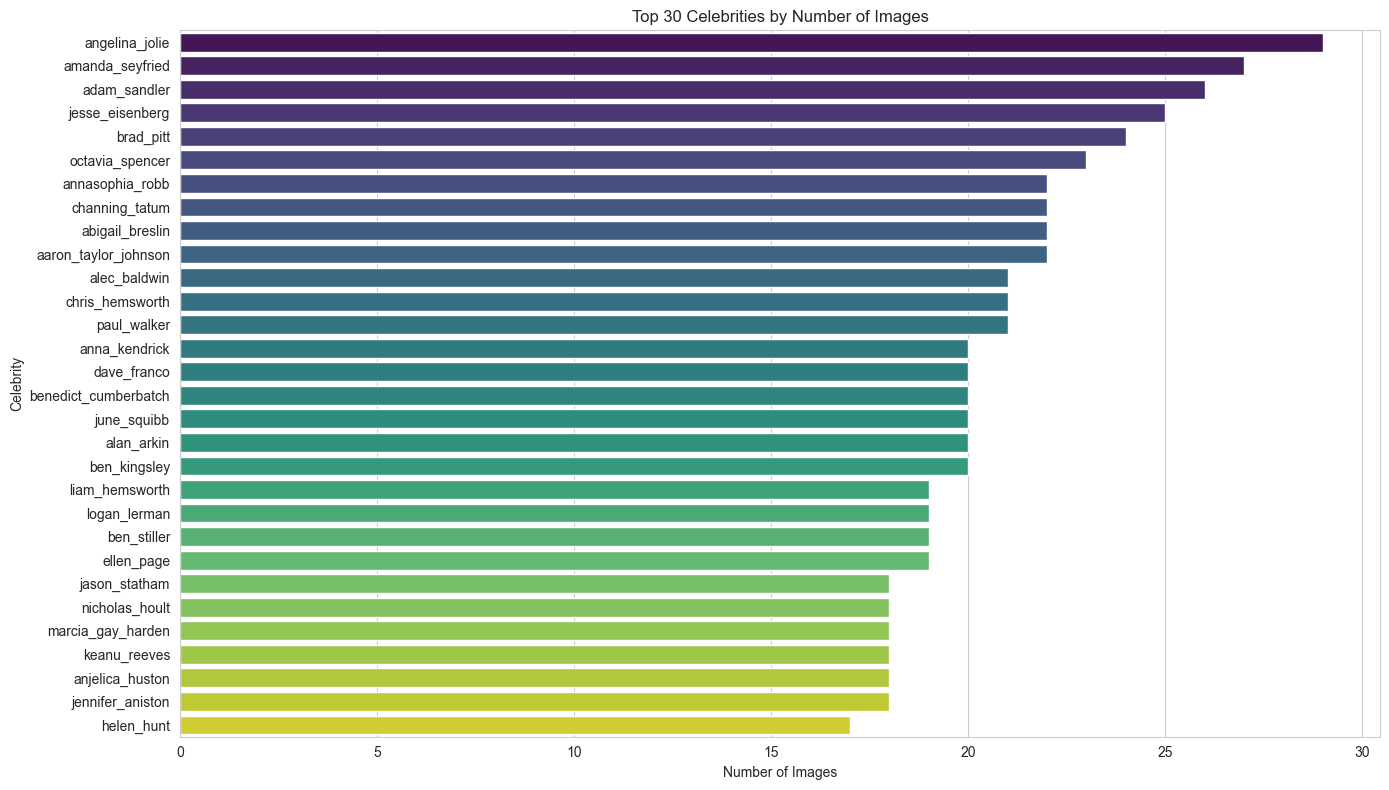

In [5]:
plt.figure(figsize=(14, 8))
top_n = 30
sns.barplot(
    data=count_per_celeb.sort_values("image_count", ascending=False).head(top_n),
    y="celebrity",
    x="image_count",
    palette="viridis",
)
plt.title(f"Top {top_n} Celebrities by Number of Images")
plt.xlabel("Number of Images")
plt.ylabel("Celebrity")
plt.tight_layout()
plt.show()

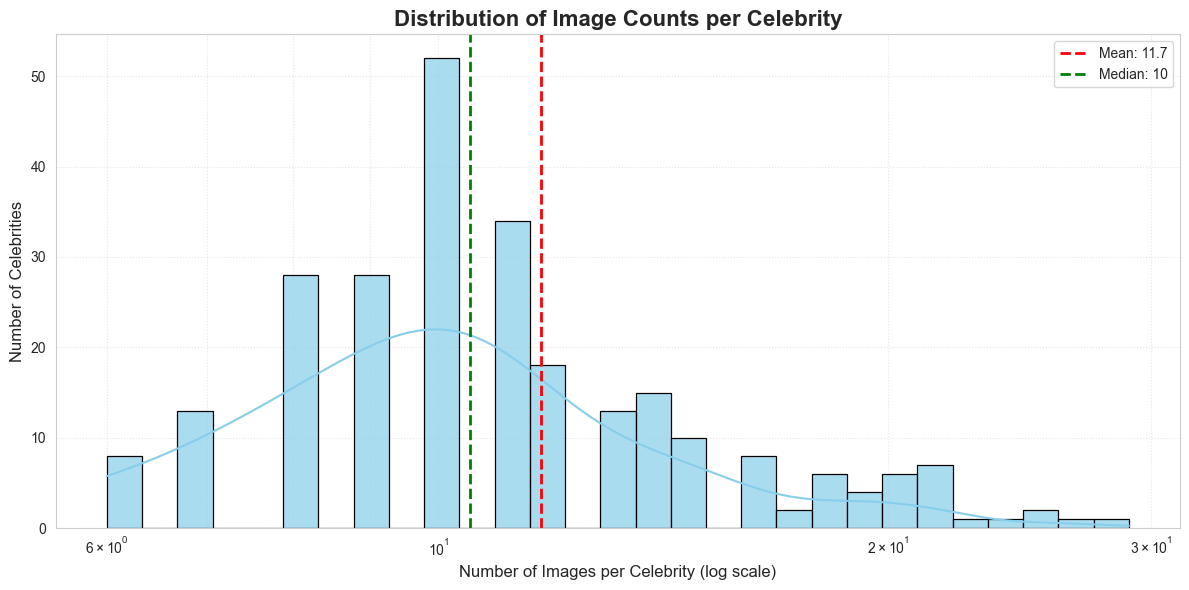

Total celebrities: 258
Total images: 3,025
Average images per celeb: 11.7
Median images per celeb: 10.5
Most images: 29 (by angelina_jolie)


In [9]:
# --- Histogram: Image Count Distribution per Celebrity ---
plt.figure(figsize=(12, 6))

# Use log-scaled bins for better visibility of long tail
bins = np.logspace(
    np.log10(max(1, count_per_celeb["image_count"].min())),
    np.log10(count_per_celeb["image_count"].max()),
    30,
)

sns.histplot(
    data=count_per_celeb,
    x="image_count",
    bins=bins,
    kde=True,
    color="skyblue",
    edgecolor="black",
    alpha=0.7,
)

plt.xscale("log")  # Log scale on x-axis
plt.title("Distribution of Image Counts per Celebrity", fontsize=16, fontweight="bold")
plt.xlabel("Number of Images per Celebrity (log scale)", fontsize=12)
plt.ylabel("Number of Celebrities", fontsize=12)

# Add vertical lines for key stats
mean_count = count_per_celeb["image_count"].mean()
median_count = count_per_celeb["image_count"].median()

plt.axvline(
    mean_count,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {mean_count:.1f}",
)
plt.axvline(
    median_count,
    color="green",
    linestyle="--",
    linewidth=2,
    label=f"Median: {median_count:.0f}",
)

plt.legend()
plt.grid(True, which="both", ls=":", alpha=0.5)
plt.tight_layout()
plt.show()

# Print summary stats
print(f"Total celebrities: {len(count_per_celeb):,}")
print(f"Total images: {count_per_celeb['image_count'].sum():,}")
print(f"Average images per celeb: {mean_count:.1f}")
print(f"Median images per celeb: {median_count}")
print(
    f"Most images: {count_per_celeb['image_count'].max()} (by {count_per_celeb.iloc[count_per_celeb['image_count'].idxmax()]['celebrity']})"
)

Showing random samples of the dataset

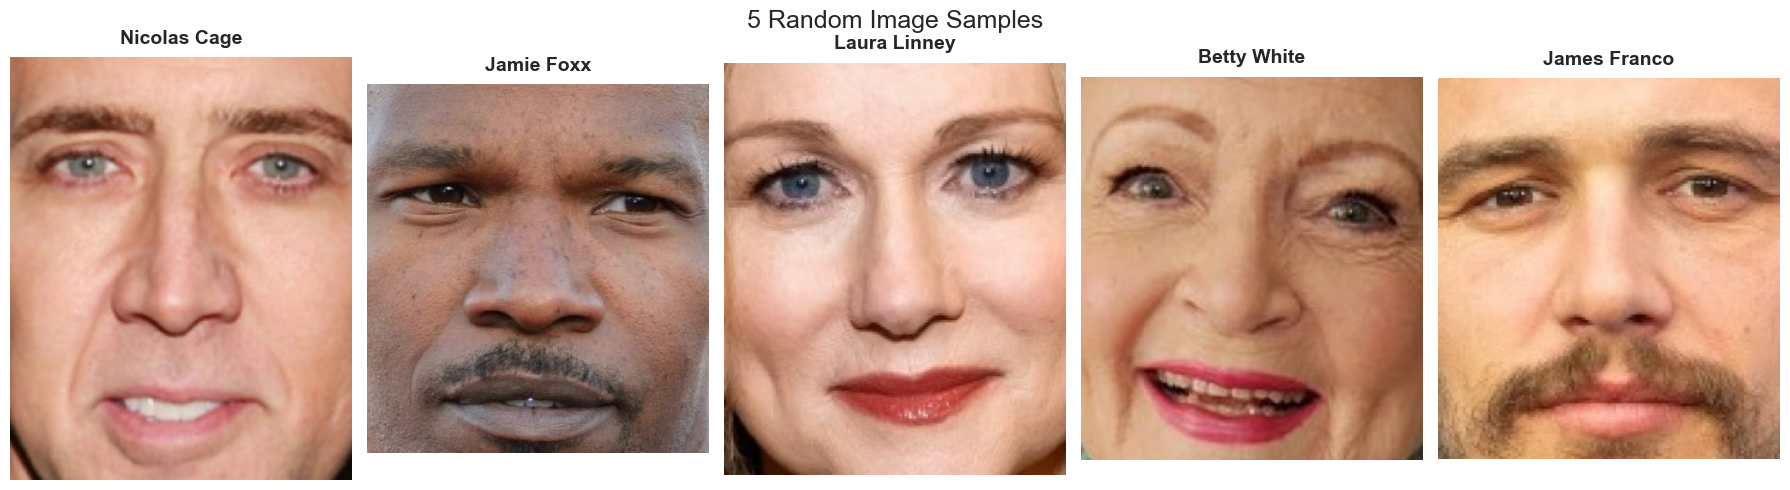

In [7]:
import numpy as np


def show_random_samples(df: pd.DataFrame, n_celebs: int = 5, seed: int = 42):
    """
    Randomly pick `n_celebs` celebrities and show one random image each.
    """
    rng = np.random.default_rng(seed)

    selected_celebs = rng.choice(df["celebrity"].unique(), size=n_celebs, replace=False)

    selected_rows = []
    for celeb in selected_celebs:
        celeb_images = df[df["celebrity"] == celeb]
        random_image_row = celeb_images.sample(n=1, random_state=rng).iloc[0]
        selected_rows.append(random_image_row)

    samples_df = pd.DataFrame(selected_rows).reset_index(drop=True)

    fig, axes = plt.subplots(1, 5, figsize=(18, 5))
    for ax, (_, row) in zip(axes, samples_df.iterrows()):
        img = Image.open(row["image_path"])
        ax.imshow(img)
        ax.set_title(
            row["celebrity"].replace("_", " ").title(),
            fontsize=14,
            fontweight="bold",
            pad=10,
        )
        ax.axis("off")

    plt.suptitle("5 Random Image Samples", fontsize=18, y=0.98)
    plt.tight_layout()
    plt.show()


show_random_samples(df, n_celebs=5, seed=42)

Analyze resoultions of images


--- Image Resolution Summary ---
             width       height
count  3025.000000  3025.000000
mean    188.268760   216.165620
std      80.504355    92.394126
min      42.000000    37.000000
25%     126.000000   142.000000
50%     167.000000   193.000000
75%     245.000000   282.000000
max     581.000000   643.000000


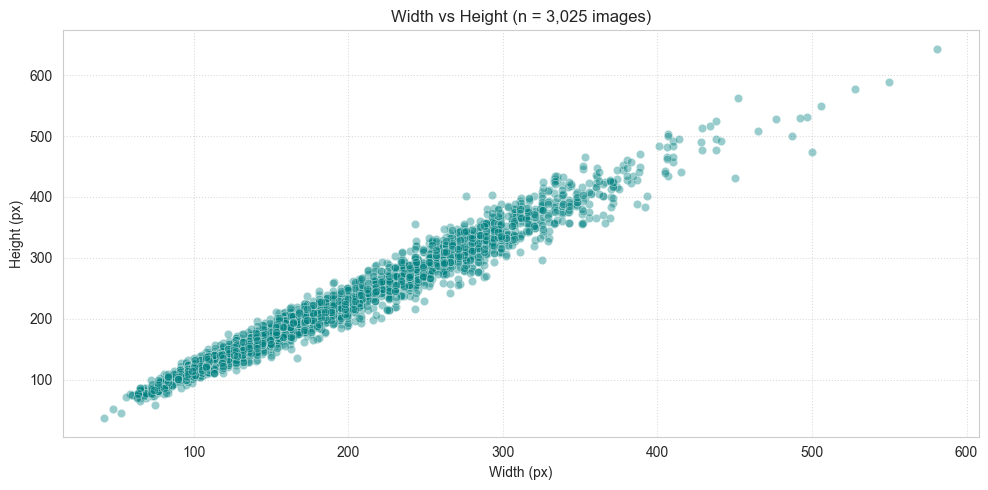

In [8]:
print("\n--- Image Resolution Summary ---")
print(df[["width", "height"]].describe())

# --- Scatterplot: Width vs Height (sample up to 5,000) ---
n_total = len(df)
n_sample = min(5_000, n_total)

plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=df.sample(n=n_sample, random_state=1),
    x="width",
    y="height",
    alpha=0.4,
    color="teal",
)
plt.title(f"Width vs Height (n = {n_sample:,} images)")
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.grid(True, ls=":", alpha=0.7)
plt.tight_layout()
plt.show()